In [10]:
# Cell 1: Imports
import os
import time
from typing import List, Dict, Tuple, Optional, Any

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import matplotlib.pyplot as plt


In [12]:
# Cell 2: IPEX Detection
try:
    import intel_extension_for_pytorch as ipex
    print("Intel Extension for PyTorch (IPEX) found.")
    USE_IPEX = True
except ImportError:
    print("Warning: IPEX not found. Proceeding without IPEX optimizations.")
    USE_IPEX = False

# Cell 3: Configuration
TRAIN_FILE      = os.path.join(os.getcwd(), 'OlidPreprcessed', 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
MODEL_NAME      = 'bert-base-uncased'
TASK            = 'a'                # OLID Sub-task A
MAX_LEN         = 100
BATCH_SIZE      = 8
EPOCHS          = 1
LEARNING_RATE   = 2e-5
SEED            = 42
SAMPLE_SIZE     = 1000
NUM_VIZ_EXAMPLES = 5

# Cell 4: Environment Setup
def setup_environment(seed: int) -> torch.device:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if USE_IPEX and hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device('xpu')
        print(f"Using IPEX XPU (count={torch.xpu.device_count()})")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

device = setup_environment(SEED)

Intel Extension for PyTorch (IPEX) found.
Using CUDA: NVIDIA GeForce RTX 2080 Ti


In [13]:
# Cell 5: Data Loading and Sampling
def load_data(filepath: str, task: str = 'a') -> Tuple[Optional[pd.DataFrame], int]:
    """Loads OLID data for the specified subtask, returns DataFrame and number of labels."""
    # Check file existence
    if not os.path.isfile(filepath):
        raise FileNotFoundError(
            f"Data file not found at '{filepath}."
            "Please ensure the file is in the working directory or update the path."
            f"Current directory contents: {os.listdir(os.getcwd())}"
        )
    # Read TSV with warning on bad lines
    df = pd.read_csv(filepath, sep='	', on_bad_lines='warn')
    if 'tweet' not in df.columns:
        raise ValueError("Required column 'tweet' is missing from the input file.")
    df['tweet'] = df['tweet'].astype(str).fillna("")

    # Task-specific settings
    configs = {
        'a': {'label_col':'subtask_a', 'positive':'OFF', 'num_labels':2, 'filter':None},
        'b': {'label_col':'subtask_b', 'positive':'TIN', 'num_labels':2, 'filter':('subtask_a','OFF')},
        'c': {'label_col':'subtask_c', 'label_map':{'IND':0,'GRP':1,'OTH':2}, 'num_labels':3, 'filter':('subtask_b','TIN')}
    }
    if task not in configs:
        raise ValueError(f"Invalid task '{task}'. Choose from {list(configs.keys())}.")
    cfg = configs[task]

    # Optional filtering for subtasks B/C
    if cfg['filter'] is not None:
        col, val = cfg['filter']
        df = df[df[col] == val].reset_index(drop=True)

    # Extract and map labels
    raw = df[cfg['label_col']]
    if 'label_map' in cfg:
        labels = raw.map(cfg['label_map']).dropna().astype(int)
    else:
        labels = (raw.str.upper() == cfg['positive']).astype(int)
    if labels.empty:
        raise ValueError("No valid labels after processing. Check the label column values.")

    df = pd.DataFrame({'tweet': df['tweet'], 'label': labels})
    return df.reset_index(drop=True), cfg['num_labels']

# Load full dataset
full_df, num_labels = load_data(TRAIN_FILE, TASK)
assert full_df is not None and not full_df.empty, "No data loaded."

print(f"Sampling up to {SAMPLE_SIZE} examples...")
if len(full_df) > SAMPLE_SIZE:
    train_df = full_df.sample(SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)
else:
    train_df = full_df.copy()
print("Sampled label distribution:")
print(train_df['label'].value_counts(normalize=True))

Sampling up to 1000 examples...
Sampled label distribution:
label
0    0.643
1    0.357
Name: proportion, dtype: float64


In [14]:
# Cell 6: Dataset & DataLoader
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class TextClassificationDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: BertTokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(text, padding='max_length', truncation=True,
                              max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_ds = TextClassificationDataset(
    train_df['tweet'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    MAX_LEN
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [15]:
# Cell 7: Model, Optimizer, and IPEX
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    output_attentions=True
).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

if USE_IPEX and device.type=='xpu':
    try:
        dtype = torch.bfloat16 if ipex.get_device_capability(device)['bf16'] else torch.float32
        model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=dtype)
        print(f"IPEX optimized with dtype {dtype}.")
    except Exception as e:
        print(f"IPEX optimization failed: {e}")

# Cell 8: Training Loop
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        loss = model(input_ids=ids, attention_mask=mask, labels=labels).loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {epoch_loss/len(train_loader):.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1/1 — Loss: 0.6438


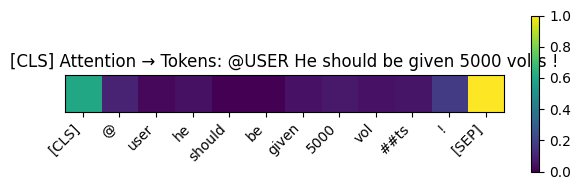

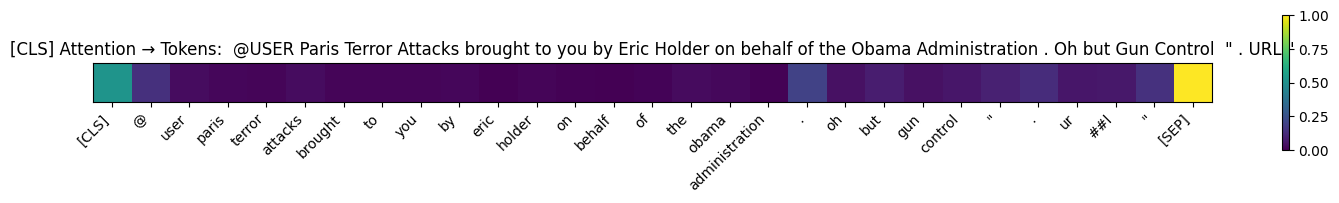

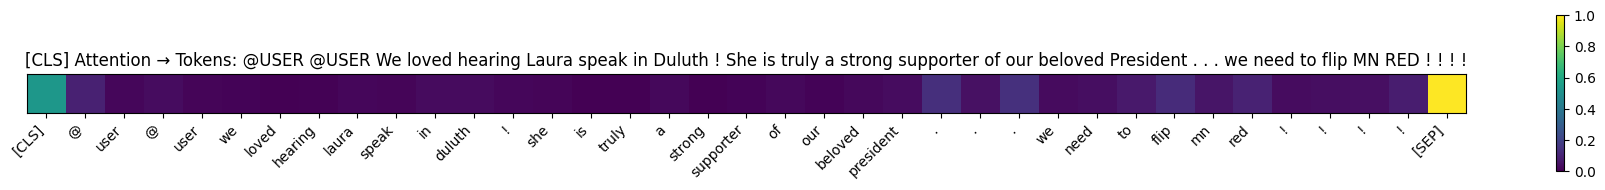

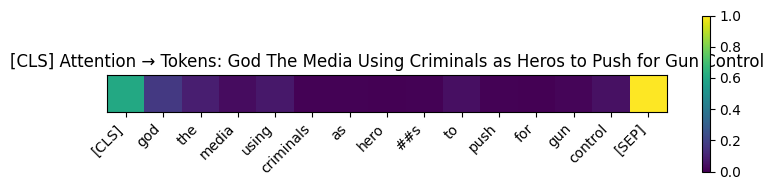

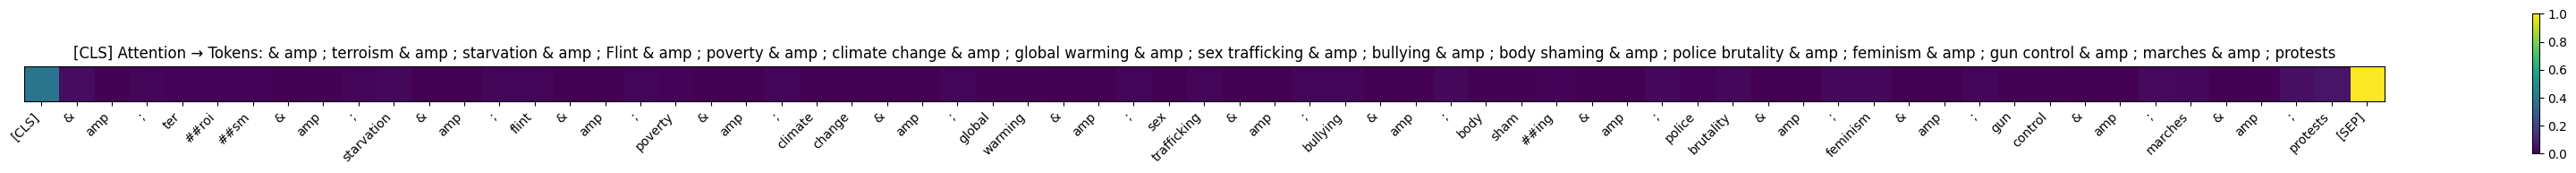

In [16]:
# Cell 9: Attention Visualization Function

def visualize_attention(model: nn.Module, tokenizer: BertTokenizer, text: str, device: torch.device, max_len: int):
    model.eval()
    enc = tokenizer(text, padding='max_length', truncation=True,
                    max_length=max_len, return_tensors='pt')
    ids = enc['input_ids'].to(device)
    mask = enc['attention_mask'].to(device)
    with torch.no_grad():
        outs = model(ids, mask, output_attentions=True)
    attns = outs.attentions
    # average CLS-attn over heads and layers
    cls_sum = torch.zeros(attns[0].size(-1), device=device)
    for layer in attns:
        avg_head = layer[0].mean(dim=0)
        cls_sum += avg_head[0]
    scores = (cls_sum/len(attns)).cpu().numpy()
    toks = tokenizer.convert_ids_to_tokens(ids[0].cpu().tolist())
    mask_np = mask[0].cpu().numpy().astype(bool)
    toks = [t for t,m in zip(toks, mask_np) if m]
    scores = scores[mask_np]
    # normalize
    mn, mx = scores.min(), scores.max()
    norm = (scores - mn)/(mx - mn + 1e-10)
    plt.figure(figsize=(len(toks)*0.5,2))
    plt.imshow([norm])
    plt.colorbar()
    plt.xticks(range(len(toks)), toks, rotation=45, ha='right')
    plt.yticks([])
    plt.title(f"[CLS] Attention → Tokens: {text}")
    plt.tight_layout()
    plt.show()

# Cell 10: Run Visualization
examples = train_df['tweet'].sample(NUM_VIZ_EXAMPLES, random_state=SEED).tolist()
for sent in examples:
    visualize_attention(model, tokenizer, sent, device, MAX_LEN)
